# Chapter 20: Overlap in Observational Studies: Difficulties and Opportunities

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf

# viz
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

font = {"family": "IBM Plex Sans Condensed", "weight": "normal", "size": 10}
plt.rc("font", **font)
plt.rcParams["figure.figsize"] = (10, 10)
%matplotlib inline

from utils import *

np.random.seed(42)
%load_ext autoreload
%autoreload 1

%load_ext watermark
%watermark --iversions

matplotlib_inline: 0.1.6
seaborn          : 0.13.0
graphviz         : 0.20.1
statsmodels      : 0.14.0
pandas           : 2.0.3
scipy            : 1.11.1
numpy            : 1.24.3
matplotlib       : 3.7.2



## drinking age RD figure

In [2]:
mlda = pd.read_csv("mlda.csv")
mlda.head()

,agecell,all,internal,external,alcohol,homicide,suicide,mva,drugs,externalother
0,19.068493,92.825401,16.617590,76.207817,0.639138,16.316818,11.203714,35.829327,3.872425,8.534373
1,19.150684,95.100739,18.327684,76.773056,0.677409,16.859964,12.193368,35.639256,3.236511,8.655786
2,19.232876,92.144295,18.911053,73.233238,0.866443,15.219254,11.715812,34.205650,3.202071,8.513741
3,19.315069,88.427757,16.101770,72.325981,0.867308,16.742825,11.275010,32.278957,3.280689,8.258285
4,19.397261,88.704941,17.363520,71.341415,1.019163,14.947726,10.984314,32.650967,3.548198,8.417533


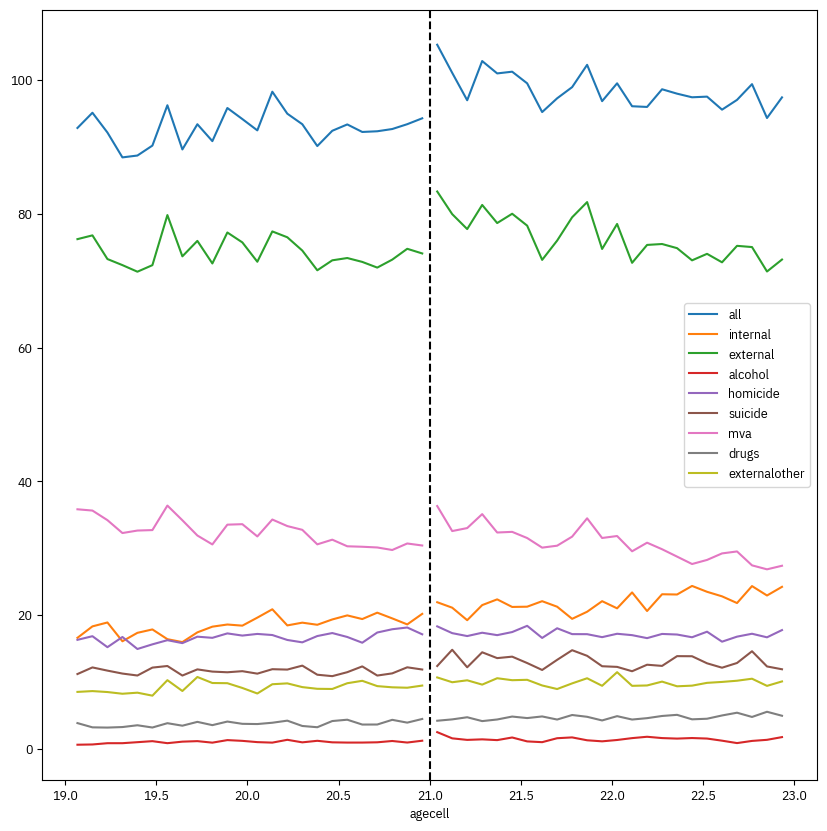

In [3]:
f, ax = plt.subplots(figsize=(10, 10))
mlda.set_index("agecell").plot(
    ax=ax,
)
ax.axvline(21, color="k", linestyle="--")

## simulated data

In [4]:
n = 500


def sim_rd_dgp(tau, x0=1, x1=0, y01=1, n=500):
    df, gr = simulate(
        x=lambda: np.random.normal(0, 1, n),
        y0=lambda x: x0 * x + np.random.normal(0, 0.5, n),
        y1=lambda y0, x: y0 * y01 + x1 * x + tau + x1 * np.random.normal(0, 0.5, n),
        z=lambda x: 1 * (x >= 0),
        y=lambda y0, y1, z: z * y1 + (1 - z) * y0,
    )
    return df


def plot_rd(df, ax):
    ax.scatter(df["x"], df["y0"], color="grey", s=1)
    ax.scatter(df["x"], df["y1"], color="grey", s=1)
    ax.scatter(df["x"], df["y"], color="black", s=1)
    ax.axvline(0, color="k", linestyle="--")

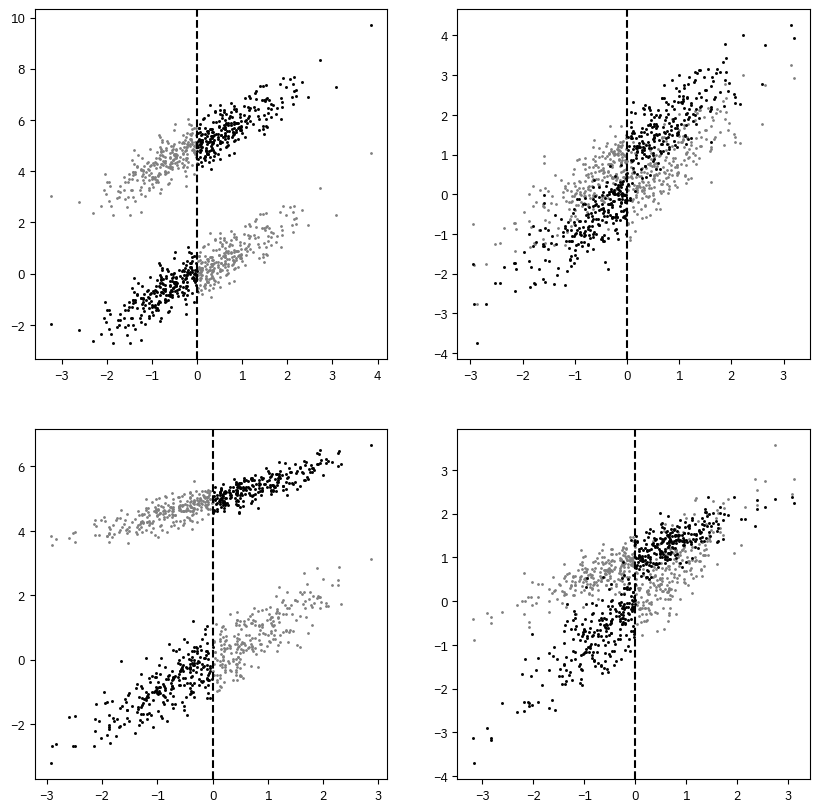

In [5]:
f, ax = plt.subplots(2, 2, figsize=(10, 10))
plot_rd(sim_rd_dgp(5), ax[0, 0])
plot_rd(sim_rd_dgp(1), ax[0, 1])
plot_rd(sim_rd_dgp(5, y01=0, x1=0.5), ax[1, 0])
plot_rd(sim_rd_dgp(1, y01=0, x1=0.5), ax[1, 1])

## Lee (2008)

In [6]:
house = pd.read_csv("house.csv")[1:]
house.head()

,Unnamed: 0,x,y
1,2,0.1393,0.4611
2,3,-0.0736,0.5434
3,4,0.0868,0.5846
4,5,0.3994,0.5803
5,6,0.1681,0.6244


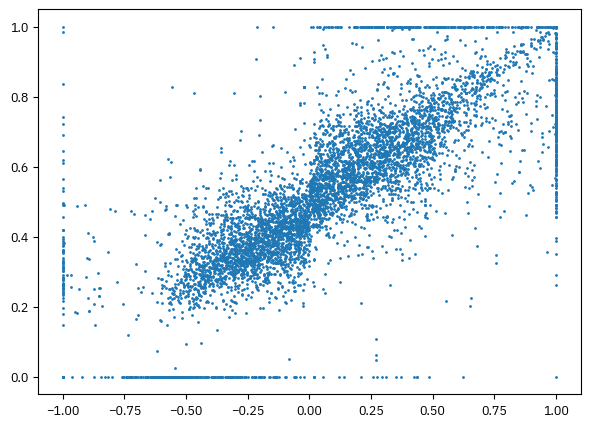

In [7]:
f = plt.figure(figsize=(7, 5))
plt.scatter(house.x, house.y, s=1)

In [8]:
house["z"] = 1 * (house.x >= 0)

In [9]:
hh = np.arange(0.05, 1, 0.01)


def fit_rd(h):
    mod = smf.ols("y ~ z * x", data=house.loc[np.abs(house.x) <= h]).fit(
        vcov_type="HC2"
    )
    return mod.params[1], mod.bse[1]


res = np.array([fit_rd(h) for h in hh])

Text(0.5, 1.0, 'Subset Linear Regression: |X| < h')

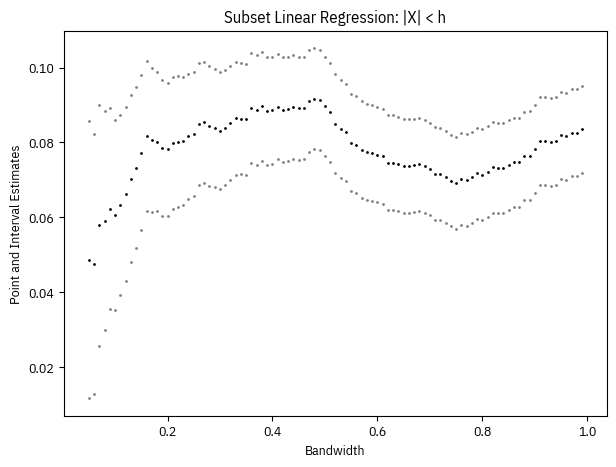

In [10]:
f, ax = plt.subplots(figsize=(7, 5))

ax.scatter(hh, res[:, 0], marker="o", color="k", s=1)
ax.scatter(hh, res[:, 0] + 1.96 * res[:, 1], color="grey", marker="o", s=1)
ax.scatter(hh, res[:, 0] - 1.96 * res[:, 1], color="grey", marker="o", s=1)
ax.set_xlabel("Bandwidth")
ax.set_ylabel("Point and Interval Estimates")
ax.set_title("Subset Linear Regression: |X| < h")